Time Cost:5.2 s
 Width:10.7 ms(0.8) 
 Scatter tail:10.4 ms(1.0)


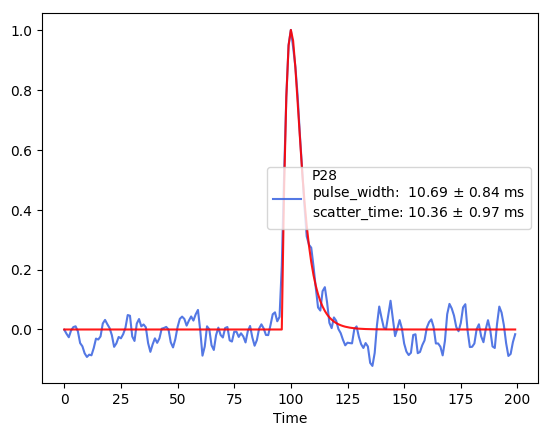

In [11]:
#!/usr/bin/env python3

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os,re,glob,time
from scipy.optimize import curve_fit


global T0

def smooth(x, window_len=5, window='hanning'):
    if x.ndim != 1:
        raise (ValueError, "smooth only accepts 1 dimension arrays.")
    if x.size < window_len:
        raise (ValueError, "Input vector needs to be bigger than window size.")
    if window_len<3:
        return x
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise (ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")

    s = np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w = np.ones(window_len,'d')
    else:
        w = eval('np.'+window+'(window_len)')
    y = np.convolve(w/w.sum(),s,mode='valid')
    return y

def scatter_f1(x, pw, tau_s, t0):

    N = len(x)
    fv, parA = 1250, 20

    freq_num = abs(int((bp_r - bp_l) / delta_f))

    times, freq = np.meshgrid(np.arange(N)*delta_t, bp_l+np.arange(freq_num)*delta_f)
    tau_nu = tau_s * (freq/fv)**-4.0

    kk = times/delta_t - np.round(t0/delta_t)
    tau = delta_t * (np.repeat((-np.arange(np.max(kk))-1)[:, np.newaxis], repeats=freq_num*N, axis=1).reshape(int(np.max(kk)), freq_num, N) + kk)
    tau[tau<0.5] = -np.inf

    AA = (1 / np.sqrt(2 * np.pi * pw**2)) * np.exp(-0.5 * (tau/pw)**2.0)
    BB = (1.0/tau_nu) * np.exp(-((times-tau-t0)/tau_nu))
    CC = np.sum(np.sum(AA * BB, axis=0)* parA, axis=0)
    CC = CC/CC.max()

    return CC


def scatter_f2(x, *para):
    '''
    Fitting with fixed t0
    '''
    pw=para[0]
    tau_s=para[1]
    N = len(x)
    fv, parA = 1250, 20

    freq_num = abs(int((bp_r - bp_l) / delta_f))

    times, freq = np.meshgrid(np.arange(N)*delta_t, bp_l+np.arange(freq_num)*delta_f)
    tau_nu = tau_s * (freq/fv)**-4.0

    kk = times/delta_t - np.round(T0/delta_t)
    tau = delta_t * (np.repeat((-np.arange(np.max(kk))-1)[:, np.newaxis], repeats=freq_num*N, axis=1).reshape(int(np.max(kk)), freq_num, N) + kk)
    tau[tau<0.5] = -np.inf

    AA = (1 / np.sqrt(2 * np.pi * pw**2)) * np.exp(-0.5 * (tau/pw)**2.0)
    BB = (1.0/tau_nu) * np.exp(-((times-tau-T0)/tau_nu))
    CC = np.sum(np.sum(AA * BB, axis=0)* parA, axis=0)
    CC = CC/CC.max()

    return CC

if __name__ == '__main__':
        delta_t = 1.573         #ms
        delta_f = 3.90625       #MHz
        bp_l    = 1300          #MHz P28 For example
        bp_r    = 1450          #MHz P28 For example

        data = np.load("Profile.npy")

        #data = data[data.size/2-100:data.size/2+100]
        data = data[np.argmax(data)-100:np.argmax(data)+100]
        data = (data - np.median(data))
        data = smooth(data)[2:-2]
        data = data / np.max(data)

        # Init value (Assume the peak is at of the center)
        p0 = [5, 15, 145]

        start = time.time()

        #Start Fitting
        popt, pcov = curve_fit(scatter_f1, np.arange(len(data)), data, method='dogbox', p0=p0, bounds=([1, 1, 130], [20, 20, 155]))

        #Iterate fitting
        #Constrain the boundary based on the result of first fit
        popt, pcov = curve_fit(scatter_f1, np.arange(len(data)), data, method='dogbox', bounds=(popt-7, popt+7))

        print('Time Cost:%.1f s'%(time.time()-start))

        #Fitting with fixed t0 which from the last fit.

        pw, pw_std, tau, tau_std, T0 = popt[0], np.sqrt(pcov[0, 0]), popt[1], np.sqrt(pcov[1, 1]), popt[2]

        p1 = [pw, tau]

        popt, pcov = curve_fit(scatter_f2, np.arange(len(data)), data, method='dogbox', p0=p1, bounds=([1, 1], [20, 20]))
        pw, pw_std, tau, tau_std= popt[0], np.sqrt(pcov[0, 0]), popt[1], np.sqrt(pcov[1, 1])
        
        print(' Width:%.1f ms(%.1f) \n Scatter tail:%.1f ms(%.1f)'%(pw*2, pw_std*2, tau, tau_std))

        #Make Figure
        plt.style.use('default')
        plt.plot(data, 'royalblue', alpha=0.9,
                 label='P28\npulse_width:  {} $\pm$ {} ms\nscatter_time: {} $\pm$ {} ms'.format(*np.round([pw*2, pw_std*2, tau, tau_std], 2)))
        plt.plot(scatter_f2(np.arange(len(data)), *popt), 'r', alpha=0.9)
        data_fit=scatter_f2(np.arange(len(data)), *popt)
        plt.xlabel('Time')
        plt.legend()
#       plt.savefig('{0:02d}-s'.format(28), dpi=300, bbox_inches='tight')
        plt.show()